# Quora Question Pairs Capstone Project

* Description

Quora is a Question - Answer forum where anyone can share their knowledge on anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month resulting in similar questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. This is where our problem and solution comes into the picture.

**Problem & Intented solution**
- Identify questions that are already asked on Quora which are duplicates. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- The main intention is to predicting whether a pair of questions are duplicates or not. 

**Main Source of Data and other information:** https://www.kaggle.com/c/quora-question-pairs

As described in my proposal first we will do a cursory check on the data by taking basic statistics and plotting them, followed by data cleansing and transformation.


**Reason to choose this as a Machine Learning Project**

As we know Qoura is a site that deals with questions and answers which obviosly asks by humans so a lot of common words, sentences, questions with same intents are asked. Now the nature of the problem itself asks for a pattern to find so that we could easily take into consideration a pattern, a pattern where we can understand the not just common words and sentences but also we'd like to generalise it on future questions as well. Now of course this deals with human language which makes it an easy decision to choose NLP. There's a context that we derive from everything someone asks a question. Whether they imply something specific or in how that has been asked which means something enitirely. NLP helps us finding this contextual patterns. Now NLP can give us the pattern, most used words & even sentences, it might help us taking our data and making it ready so that ultimately in future we can content two or multiple questions and understand whether or not it has been asked with same content. Also, in a fair context it is a binary classification problem i.e. for a given pair of questions we need to predict if they are duplicate or not.

**Useful link for similar studies**

https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0 <br>
https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning <br>

In [1]:
# Improting Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os,re,gc
from os import path
from PIL import Image
from bs4 import BeautifulSoup #scraping purpose
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pallete = sns.color_palette()

# 1. Basic EDA & Plots

In [2]:
train_data = pd.read_csv("train.csv")
print("Total training data points:",train_data.shape[0])

Total training data points: 404290


In [4]:
train_data.info() #A basic structure of our data, 404290 rows of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
train_data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


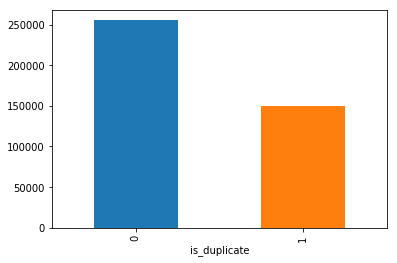

In [7]:
#Number of duplicate and non-duplicate questions in a bar plot
train_data.groupby("is_duplicate")['id'].count().plot.bar()

In [4]:
print('Question pairs that are not Duplicate: {}%'.format(100 - round(train_data['is_duplicate'].mean()*100, 2)))
print('Question pairs that are Duplicate: {}%'.format(round(train_data['is_duplicate'].mean()*100, 2)))

Question pairs that are not Duplicate: 63.08%
Question pairs that are Duplicate: 36.92%


In [9]:
qids = pd.Series(train_data['qid1'].tolist() + train_data['qid2'].tolist())
unique_ques = len(np.unique(qids))
ques_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of unique ques are: {}\n'.format(unique_ques))

print ('Number of unique questions that appear more than one time: {}, {}%'.format(ques_morethan_onetime,ques_morethan_onetime/unique_ques*100))
print ('Maximum number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of unique ques are: 537933

Number of unique questions that appear more than one time: 111780, 20.77953945937505%
Maximum number of times a single question is repeated: 157


In [10]:
#checking for any repeated pair of questions

ques_pair_duplicates = train_data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(ques_pair_duplicates).shape[0] - train_data.shape[0])

Number of duplicate questions 0


In [11]:
#Checking for any rows with any null values
null_rows = train_data[train_data.isnull().any(1)]
print(null_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  
105780          2          2   30.0    NaN  
201841          1          2   32.0    NaN  
363362          1          1    NaN  123.0  


In [12]:
#filling the null values in question 2 with an empty string

train_data = train_data.fillna('')
null_rows = train_data[train_data.isnull().any(1)]
print(null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len]
Index: []


Null Values adjusted

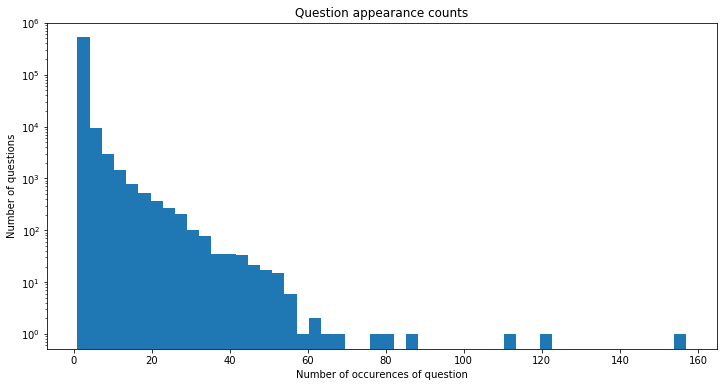

In [13]:
plt.figure(figsize=(12, 6))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

Maximum number of times a single question is repeated: 157, This analogy is is now clear from th graph itself.

# 2. Basic Feature Extraction - Raw

In [13]:
#To do some basic feature extraction on raw data we'd like to have columns that meets our requirement of 
#undertstanding the data better:
     
train_data['freq_qid1'] = train_data.groupby('qid1')['qid1'].transform('count') #Frequency of qid1's
train_data['freq_qid2'] = train_data.groupby('qid2')['qid2'].transform('count') #Frequency of qid2's
train_data['q1len'] = train_data['question1'].str.len()                         #Length of q1
train_data['q2len'] = train_data['question2'].str.len()                         #Length of q2
train_data['q1_n_words'] = train_data['question1'].apply(lambda row: len(row.split(" "))) #Number of words in Question 1
train_data['q2_n_words'] = train_data['question2'].apply(lambda row: len(row.split(" "))) #Number of words in Question 2

def normalized_word_Common(row):
    '''This function gives number of common unique words in Question 1 and Question 2'''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)

train_data['word_Common'] = train_data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    '''This function calculates sum of total num of words in Question 1 and Total num of words in Question 2'''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

train_data['word_Total'] = train_data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    '''A ratio between [(word_common)/(word_Total)]'''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

train_data['word_share'] = train_data.apply(normalized_word_share, axis=1)
train_data['freq_q1+q2'] = train_data['freq_qid1']+train_data['freq_qid2']
train_data['freq_q1-q2'] = abs(train_data['freq_qid1']-train_data['freq_qid2'])
train_data.to_csv("train_data_fe_ext_without_preprocessing.csv", index=False)

train_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [15]:
print ("Minimum length of the questions in question1 : " , min(train_data['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(train_data['q2_n_words']))
print ("Number of Questions with minimum length [question1] :", train_data[train_data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train_data[train_data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


**Basic Plots**

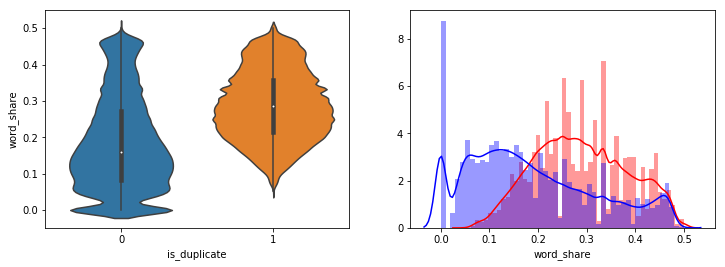

In [23]:
#Word_Share
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train_data[0:])
plt.subplot(1,2,2)
sns.distplot(train_data[train_data['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(train_data[train_data['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )

Here we can notice a couple of things such as: 
* The distributions for normalized word_share have some overlap on the right side, i.e., there are a lot of questions with high word similarity.
* The average word share and common number of words of qid1 and qid2 is more when they are duplicate.

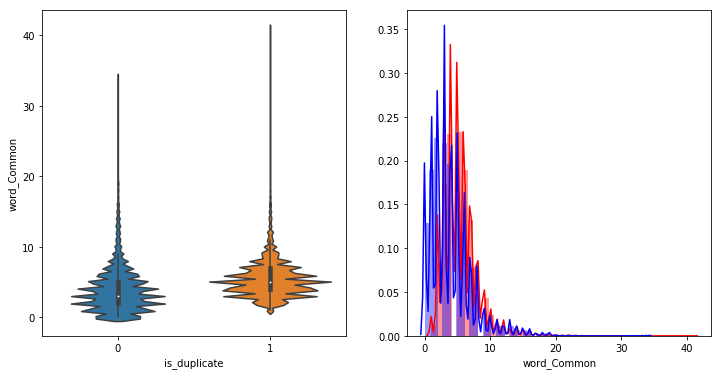

In [25]:
#Word_Common

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = train_data[0:])
plt.subplot(1,2,2)
sns.distplot(train_data[train_data['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(train_data[train_data['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )

Here we can notice that the the distributions of the word_Common feature in similar and non-similar questions are highly overlapping.

# 3. Data Pre-Processing - I

In [28]:
if os.path.isfile('train_data_fe_ext_without_preprocessing.csv'):
    train_data = pd.read_csv("train_data_fe_ext_without_preprocessing.csv",encoding='latin-1') #trying encoding latin-1 instead utf8 
    train_data = train_data.fillna('')                                                       #removing empty values
    train_data.head(2)
else:
    print("File not created!")
    
train_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [29]:
#NLP related libraries 
import nltk
nltk.download("stopwords")
from wordcloud import WordCloud
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from subprocess import check_output
from fuzzywuzzy import fuzz

div = 0.0001 #getting the results in 4 decimal point
stopwords = stopwords.words("english")


def preprocess(x):
    x = str(x).lower() #keeping everything in lowercase
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")  #replacing all the short forms into actual form
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


**Reason behind choosing few of the algorithms that we are working with in the above section**

    1. PorterStemmer: Before understanding PorterStemmer we need have an idea on why we're doing this on the first place. It is an algorithm for a process call Stemming. Stemming is the process of producing variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. For example, A stemming algorithm would reduces the words “chocolates”, “chocolatey”, “choco”, "choc" to the root word “chocolate”. Words like “retrieval”, “retrieved”, “retrieves” would reduce to the stem “retrieve”. Now why we would need this? We need this because recognizing, searching and retrieving more forms of words can give us more results. When a form of a word is recognized we can make it possible to understand the various forms of that word and tell whether two or more words have similar meaning or not. Here in our example we have tried to get the root words so that we can compoare and apply on them.
    
    2. stopwords.words("english"): "stop words" usually refers to the most common words in a language, such as “the”, “a”, “an”, “in” etc. We would not want these words taking up space in our database, or taking up valuable processing time as these words won't actually help us understanding any literal meaning of a sentence, although this is not exactly an algorithm but this process is really helpful for us to get directly towards the root or main words.

# 3. Data Pre-Processing - II

In [30]:
def get_token_features(q1, q2):
    '''When we split a sentence based space, that is called "token" 
       Stop_Word: stop words as defined in NLTK.
       Word: Any token which isn't a stopword'''
    
    token_features = [0.0]*10
    q1_tokens = q1.split()         #Converting the sentence into tokens
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    q1_words = set([word for word in q1_tokens if word not in stopwords]) #non-stopwords in Questions
    q2_words = set([word for word in q2_tokens if word not in stopwords]) 
    
    q1_stops = set([word for word in q1_tokens if word in stopwords])     #stopwords in Questions
    q2_stops = set([word for word in q2_tokens if word in stopwords])
    
    common_word_count = len(q1_words.intersection(q2_words))              #non-stopwords from question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))              #stopwords from question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens))) #common tokens from question pair
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + div)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + div)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + div)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + div)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + div)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + div)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1]) #Will hold last word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0]) #Will hold first word of both question is same or not
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2 #Average token length of both questions
    return token_features

def get_longest_substr_ratio(a, b):
    '''This function gets the longest common sub string'''
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(train_data):
    '''This function does preprocessing on  each question'''
    train_data["question1"] = train_data["question1"].fillna("").apply(preprocess)
    train_data["question2"] = train_data["question2"].fillna("").apply(preprocess)
    print("working on token features.")

    token_features = train_data.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1) #Merging features with the data
    
    #Gives the ratio of common_word_count to min lenghth of word count of Q1 and Q2 
    train_data["cwc_min"] = list(map(lambda x: x[0], token_features)) 
    #Gives the ratio of common_word_count to max lenghth of word count of Q1 and Q2 
    train_data["cwc_max"] = list(map(lambda x: x[1], token_features))
    #Gives the ratio of common_stop_count to min length of stop count of Q1 and Q2 
    train_data["csc_min"] = list(map(lambda x: x[2], token_features))
    #Gives the ratio of common_stop_count to max length of stop count of Q1 and Q2 
    train_data["csc_max"] = list(map(lambda x: x[3], token_features))
    #Gives the ratio of common_token_count to min lenghth of token count of Q1 and Q2
    train_data["ctc_min"] = list(map(lambda x: x[4], token_features))
    #Gives the ratio of common_token_count to max lenghth of token count of Q1 and Q2
    train_data["ctc_max"] = list(map(lambda x: x[5], token_features))
    #Checks if the last word of both questions are equal or not
    train_data["last_word_eq"] = list(map(lambda x: x[6], token_features))
    #Checks if the first word of both questions are equal or not
    train_data["first_word_eq"] = list(map(lambda x: x[7], token_features))
    #Checks the absolute length differences for Q1 and Q2
    train_data["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    #Checks the average token length of both Questions Q1 and Q2
    train_data["mean_len"] = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("working on fuzzy features..")

    train_data["token_set_ratio"] = train_data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    train_data["token_sort_ratio"] = train_data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    train_data["fuzz_ratio"] = train_data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    train_data["fuzz_partial_ratio"] = train_data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    train_data["longest_substr_ratio"] = train_data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return train_data

Few of the sources that I used here for the concept and codes are pinned down below:

    * https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    * https://github.com/seatgeek/fuzzywuzzy

In [31]:
if os.path.isfile('nlp_features_train_data.csv'):
    train_data = pd.read_csv("nlp_features_train_data.csv",encoding='latin-1')
    train_data.fillna('')
else:
    print("Extracting features for train_data:")
    train_data = pd.read_csv("train.csv")
    train_data = extract_features(train_data)
    train_data.to_csv("nlp_features_train_data.csv", index=False)
train_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


Here we're creating wordcloud of fuplicates and Non-duplicate pairs so that we can observe the most frequent words occuring.

In [32]:
train_data_duplicate = train_data[train_data['is_duplicate'] == 1]
train_data_nonduplicate = train_data[train_data['is_duplicate'] == 0]

p = np.dstack([train_data_duplicate["question1"], train_data_duplicate["question2"]]).flatten()
#Using flatten() to convert the 2d array of q1 and q2.
nd = np.dstack([train_data_nonduplicate["question1"], train_data_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(nd))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding="utf-8")
np.savetxt('train_nd.txt', nd, delimiter=' ', fmt='%s',encoding="utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


Reading the files that we've just created

Wordcloud for duplicate question pairs


(-0.5, 399.5, 199.5, -0.5)

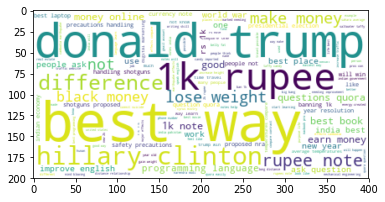

In [18]:
#Generating Wordcloud for most used words from duplicate pair question

wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords) #generating wordcloud object
wc.generate(textp_w)
print("Wordcloud for duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("on")

Wordcloud for non-duplicate question pairs


(-0.5, 399.5, 199.5, -0.5)

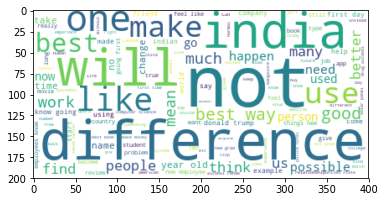

In [19]:
#Generating Wordcloud for most used words from non - duplicate pair question

wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords) #generating wordcloud object
wc.generate(textnd_w)
print("Wordcloud for non-duplicate question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("on")

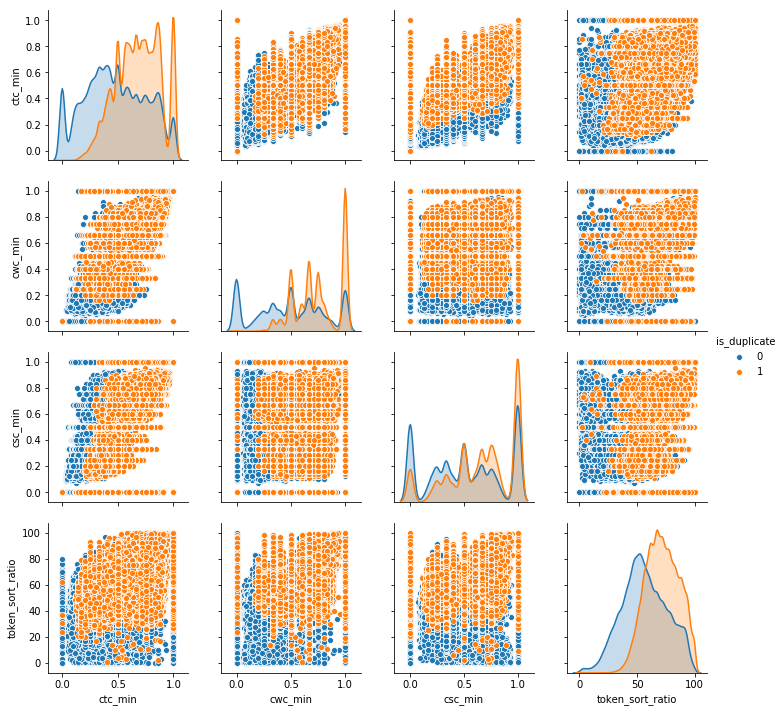

In [33]:
n = train_data.shape[0]
sns.pairplot(train_data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', 
             vars=['ctc_min','cwc_min', 'csc_min','token_sort_ratio'])

# Calculating Word-2Vec

Source I used for implementing the below section:
    * https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/
    * https://machinelearningmastery.com/develop-word-embeddings-python-gensim/    

The goal with word2vec and most NLP embedding schemes is to translate text into vectors so that they can then be processed using operations from linear algebra. Vectorizing text data allows us to then create predictive models that use these vectors as input to then perform something useful. 

Word2Vec is a shallow, two-layer neural networks which is trained to reconstruct linguistic contexts of words. It takes as its input a large set(corpus) of words and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. So basically, Word2Vec is a simple neural network and like all neural networks, it has weights, and during training its goal is to adjust those weights to reduce a loss function. However, Word2Vec is not going to be used for the task it was trained on, instead, we will just take its hidden weights, use them as our word embeddings.

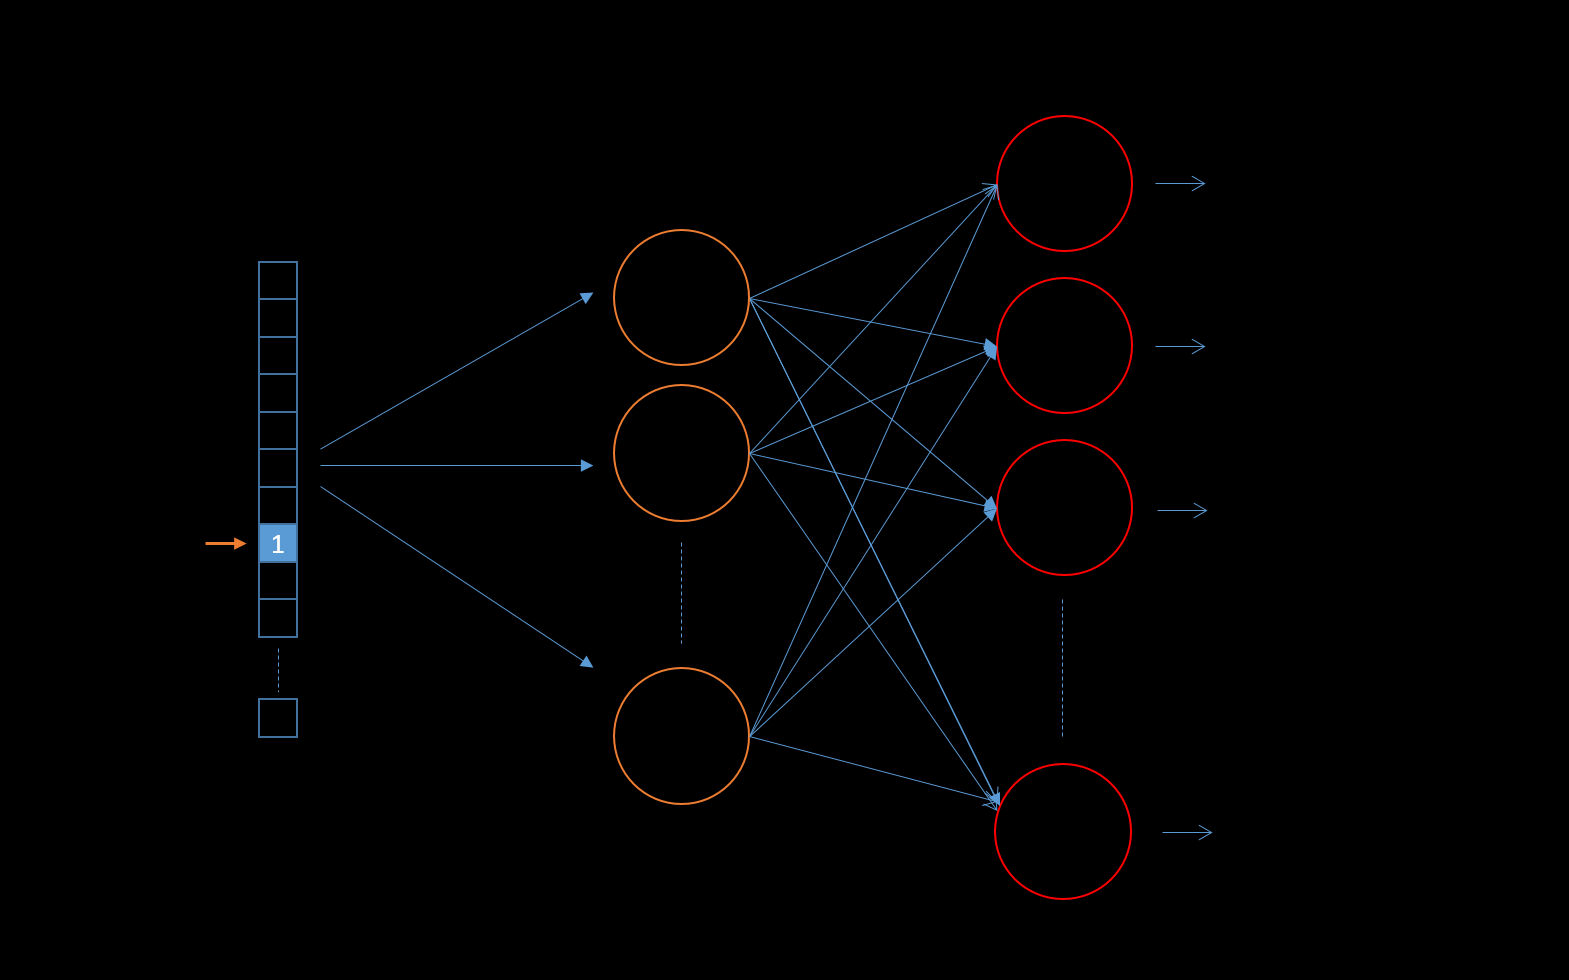

Source: https://israelg99.github.io/2017-03-23-Word2Vec-Explained/ <br>
        https://skymind.ai/wiki/word2vec

In [20]:
train_data = pd.read_csv("train.csv") #Newly imported

train_data['question1'] = train_data['question1'].apply(lambda x: str(x))
train_data['question2'] = train_data['question2'].apply(lambda x: str(x))

In [19]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

questions = list(train_data['question1']) + list(train_data['question2']) #Merging texts from questions1 & 2

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)  #Fitting the merged texts

<808580x109679 sparse matrix of type '<class 'numpy.float64'>'
	with 8146555 stored elements in Compressed Sparse Row format>

In [22]:
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_)) #An array mapping from feature integer indices to feature name

* Once we find tfidf scores we can convert each the question to a weighted average of word2vec vectors by these scores.
* Using glove which is a pre trained model for NLP processings.

In [28]:
import spacy
from tqdm import *
nlp = spacy.load('en') #Downloaded the package via "https://spacy.io/usage/vectors-similarity"

vecs1 = []
for qu1 in tqdm(list(train_data['question1'])): #tqdm is used to print the progress bar
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)]) #-> is the number of dimensions of vectors 
    for word1 in doc1:
        vec1 = word1.vector #word2vec
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += (vec1 * idf)  #final vec
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
train_data['q1_feats_m'] = list(vecs1)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [36:51<00:00, 182.84it/s]


* Resources for the above codeset and the packages:
  * "https://spacy.io/usage/vectors-similarity"
  *  https://github.com/noamraph/tqdm 
  * https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
  *https://spacy.io/models/en#en_vectors_web_lg

In [29]:
#Similar operation for train_data['question2']
from tqdm import *
vecs2 = []
for qu2 in tqdm(list(train_data['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        vec2 = word2.vector #word2vec
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf   #final vec
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
train_data['q2_feats_m'] = list(vecs2)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [37:31<00:00, 179.56it/s]


In [30]:
#Preprocessing Feartures
if os.path.isfile('nlp_features_train_data.csv'):
    dfnlp = pd.read_csv("nlp_features_train_data.csv",encoding='latin-1')
else:
    print("nlp_features_train_data file not created!!")

In [31]:
if os.path.isfile('train_data_fe_ext_without_preprocessing.csv'):
    dfppro = pd.read_csv("train_data_fe_ext_without_preprocessing.csv",encoding='latin-1')
else:
    print("File not created!!")

In [36]:
# a = pd.DataFrame(df3['q1_feats_m'].values.tolist())

In [38]:
# df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1) #dataframe of nlp features
# df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1) #dataframe of data before preprocessing 
# df3 = train_data.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1) #dataframe of main data
# df3_q1 = pd.DataFrame(df3['q1_feats_m'].values.tolist(), index= df3.index) #Questions_1 tfidf weighted word2vec
df3_q2 = pd.DataFrame(df3['q2_feats_m'].values.tolist(), index= df3.index) #Questions_2 tfidf weighted word2vec

In [44]:
# if not os.path.isfile('final_features.csv'):    #Storing every final features to a csv file
#     df3_q1['id']=df1['id']
#     df3_q2['id']=df1['id']
#     df1 = df1.merge(df2, on='id',how='left')
#     df2 = df3_q1.merge(df3_q2, on='id',how='left')
#     final_result = df1.merge(df2, on='id',how='left')
    
final_result.to_csv('final_features.csv')

# Applying all to Machine Learning Algorithms

In [3]:
import warnings, os, csv, math,sqlite3
from sqlalchemy import create_engine # database connection
warnings.filterwarnings("ignore")
import datetime as dt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [4]:
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

* Reason For creating a temp db instead of using the inal feature file:
 The main 5 reason would be: 
 1. Better Performance
 2. Content can applied using small and precise sql queries.
 3. Easy to use, load, re-load, and can make changes easily.
 4. Can be viewed in other tool also.

In [5]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None

def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables = table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [6]:
read_db = 'train.db'
conn_r = create_connection(read_db) #Creating the connection
checkTableExists(conn_r)            #Checking for the tables
conn_r.close()

Tables in the databse:
data


In [7]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:       
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)#selecting random points
        conn_r.commit()
        conn_r.close()

In [128]:
data.drop(data.index[0], inplace=True) #removing the first row 
y_true = data['is_duplicate']  #labeled data
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.749981250468738,0.599988000239995,0.399992000159997,0.285710204139941,0.555549382784636,0.384612426058261,0.0,0.0,4.0,11.0,...,None,None,None,None,None,None,None,None,None,None
2,0.999980000399992,0.714275510349852,0.799984000319994,0.799984000319994,0.899991000089999,0.749993750052083,1.0,1.0,2.0,11.0,...,None,None,None,None,None,None,None,None,None,None


In [135]:
# data2 = data
# data2.fillna(0, inplace=True)
data2.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.749981250468738,0.599988000239995,0.399992000159997,0.285710204139941,0.555549382784636,0.384612426058261,0.0,0.0,4.0,11.0,...,0,0,0,0,0,0,0,0,0,0
2,0.999980000399992,0.714275510349852,0.799984000319994,0.799984000319994,0.899991000089999,0.749993750052083,1.0,1.0,2.0,11.0,...,0,0,0,0,0,0,0,0,0,0


Converting strings to numerics

In [140]:
#Once we read from sql table each entry that was read as a string converting them all the features into numeric values before we apply any model
cols = list(data2.columns)
# data2 = pd.DataFrame(np.array(data2.values,dtype=np.float64),columns=cols)
for i in cols:
    data2[i] = data2[i].apply(pd.to_numeric)

data2.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.749981,0.599988,0.399992,0.285710,0.555549,0.384612,0.0,0.0,4.0,11.0,...,0,0,0,0,0,0,0,0,0,0
2,0.999980,0.714276,0.799984,0.799984,0.899991,0.749994,1.0,1.0,2.0,11.0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
y_true = list(map(int, y_true.values)) #labelled data
# y_true

Splitting the data into training and testing set

In [144]:
X_train,X_test, y_train, y_test = train_test_split(data2, y_true, stratify=y_true, test_size=0.3)

print("Total data points in the train data :",X_train.shape)
print("Total data points in the test data :",X_test.shape)

Total data points in the train data : (70000, 794)
Total data points in the test data : (30000, 794)


In [121]:
# np.all(np.isfinite(X_train))

True

In [145]:
print("Distribution of output variable in train data: ")
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len)
print("Class 1: ", int(train_distr[1])/train_len)
print()
print("Distribution of output variable in train data: ")
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len)
print("Class 1: ",int(test_distr[1])/test_len)

Distribution of output variable in train data: 
Class 0:  0.6299857142857143
Class 1:  0.37001428571428574

Distribution of output variable in train data: 
Class 0:  0.37
Class 1:  0.37


In [146]:
def plot_confusion_matrix(test_y, predict_y):
    #A function for plotting the confusion matrices given y_i, y_i_hat. (labelled and predicted)
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("green") #representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# A random model

Log loss on Test Data using Random Model 0.8842498979500346


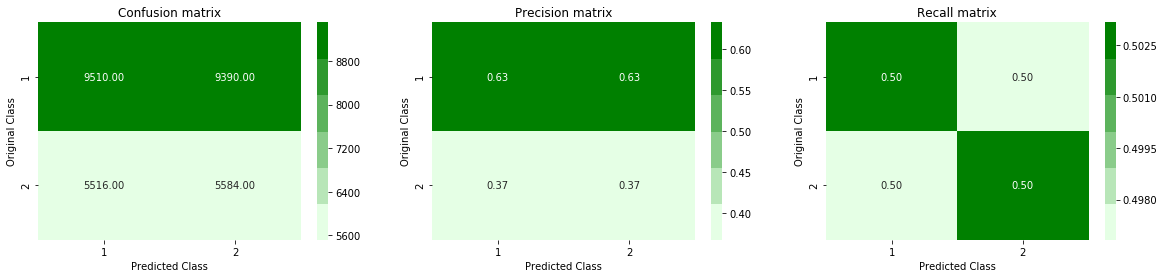

In [147]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

Why Creating a Random Model:

* This random model will help us to compare between our base model and tuned model with and without using tfidf and tfidf-w2v model.
* Source of the codeset and concept from: https://stackoverflow.com/a/18662466/4084039
* This random model would be our bench mark as for comparison between our established models which have parameter tunings and not parameterized ones.

# Logistic Regression

Logistic regression is a statistical machine learning algorithm that classifies the data by considering outcome variables on extreme ends and tries makes a logarithmic line that distinguishes between them.

formula for a linear regression: y = mx+C, 
                                 where,

                                 y = value that has to be predicted <br>
                                 m = slope of the line <br>
                                 x = input data <br>
                                 c = y intercept
Unlike linear regression, logistic regression produces a logistic curve, which is limited to values between 0 and 1 which sort of looks like this: 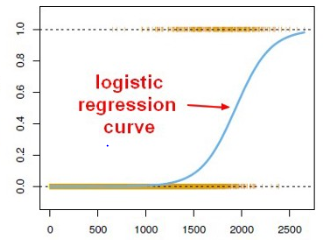 <br>

Which means, it'll either predict a class of 0 or 1. To predict which class a data belongs, a threshold can be set. Based upon this threshold, the obtained estimated probability is classified into classes. And foe example if a predicted_value is ≥ 0.5 then it'll get classify as 1 else 0. This particular decision boundary can be linear or non-linear. Polynomial order can be increased to get complex decision boundary.

Reason for choosing LR: The feature vectors that result from the prvious algorithm are usually very large. Hence the dimensions are high. So we need to use simple algorithms that are efficient on a large number of features without adding any other complexity into the picture. Also, we need an algorithm that particularly has an way we can tune them, now we can leverage L1 or an L2 for LR. so overall it's a good fit of choice. 

For values of alpha =  1e-05 The log loss is: 0.6002489940977036
For values of alpha =  0.0001 The log loss is: 0.539964706001876
For values of alpha =  0.001 The log loss is: 0.5368786761897872
For values of alpha =  0.01 The log loss is: 0.5389882909451263
For values of alpha =  0.1 The log loss is: 0.5469072297073289
For values of alpha =  1 The log loss is: 0.5254412908796925
For values of alpha =  10 The log loss is: 0.5354575427714446


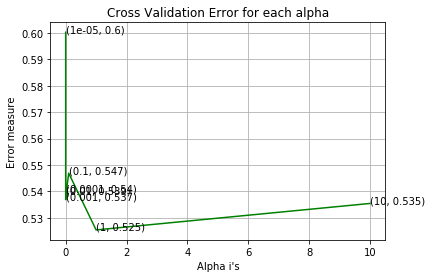

For values of best alpha =  1 The training log loss is: 0.5235023675621842
For values of best alpha =  1 The testing log loss is: 0.5254412908796925
Total number of data points : 30000


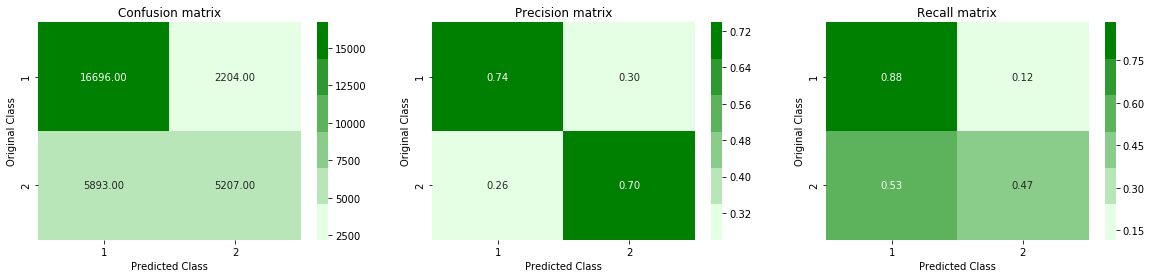

In [148]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparameter for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=1)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The training log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The testing log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

A Brief explanation on what is going on above:

* First we are pushing alpha values and for each value of alpha we are calculating log loss values. 
* This is on a total datapoints of 30000.
* SGD considers only 1 random point while changing weights unlike gradient descent which considers the whole training data. As such stochastic gradient descent is much faster than gradient descent when dealing with large data sets.
* Logistic Regression by default uses Gradient Descent and as such it would be better to use SGD Classifier on larger data sets. 
* By default, the SGD Classifier does not perform as well as the Logistic Regression. It requires some hyper parameter tuning to be done. That is what we've done here using hyperparameters like alpha, penalty, loss, random_state etc.
* Based on that series of alpha we select the best alpha and get the best log loss values.

**Gradient Boosting Model**

* Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. Gradient Boosting trains many models in a gradual, additive & sequential manner. 

* It identifies the shortcomings by using gradients in the loss function i.e. y=ax+b+e.
  where, e is the error term.

* The loss function is a measure indicating how good are model’s coefficients are at fitting the underlying data. A loss function could be defined as on what we are trying to optimise. For example, if we are trying to predict the sales prices by using a regression, then the loss function would be based off the error between true and predicted house prices.

* Gradient boosting involves three proper steps:
    A loss function to be optimized. For our problem since it is an classification algotihm we are using an logarithmic loss. 
    A weak learner to make predictions.
    An additive model to add weak learners to minimize the loss function. Trees are added one at a time, and existing trees in the model are not changed. A gradient descent procedure is used to minimize the loss when adding trees.
    
* Discussion on the hyperparameters are described below.

* So to understand what is weak and strong learner is. A weak learner is defined to be a classifier that is only slightly correlated with the true classification i.e. it can label examples better than random guessing. This also means that many instances of the algorithm are being pooled (via boosting, bagging, etc) together into to create a "strong" ensemble classifier.

* This entire process is coming from the basis of decision tree which is again a classification tree based algorithm, forwarded to random forest which is like a collection of decision tree of choosing a better learner. An ensemble. So basically this model learns from various over grown trees and a final decision is made based on the majority.  In this method, predictors are also sampled for each node. It best works on over fitted models that have low bias and high variation and is a bagged model.

* The term 'Boosting' refers to a family of algorithms which converts weak learner to strong learners. Boosting is an ensemble method for improving the model predictions of any given learning algorithm. The idea of boosting is to train weak learners sequentially, each trying to correct its predecessor. Hence, this process is known as boosting.

* A brief on how the boosting works.

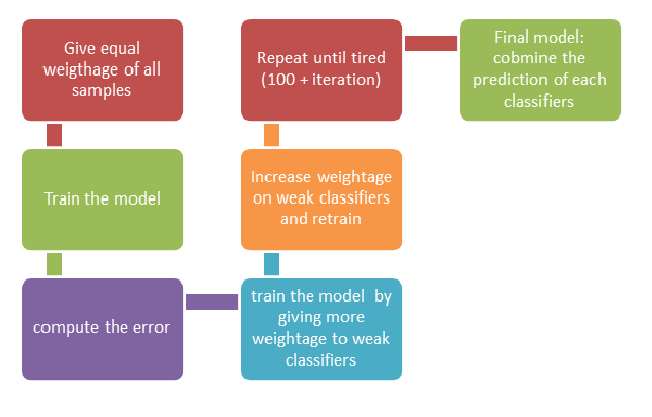

# XGBoost Model

In [150]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
params['silent'] = 1

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= 10,early_stopping_rounds=20)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684926	valid-logloss:0.684909
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615846	valid-logloss:0.615702
[20]	train-logloss:0.565236	valid-logloss:0.564883
[30]	train-logloss:0.527408	valid-logloss:0.526802
[40]	train-logloss:0.498226	valid-logloss:0.497434
[50]	train-logloss:0.475306	valid-logloss:0.474427
[60]	train-logloss:0.45705	valid-logloss:0.456034
[70]	train-logloss:0.44241	valid-logloss:0.441394
[80]	train-logloss:0.430339	valid-logloss:0.42935
[90]	train-logloss:0.420568	valid-logloss:0.419633
[100]	train-logloss:0.412219	valid-logloss:0.411279
[110]	train-logloss:0.405336	valid-logloss:0.404372
[120]	train-logloss:0.399625	valid-logloss:0.398658
[130]	train-logloss:0.394948	valid-logloss:0.394022
[140]	train-logloss:0.390957	valid-logloss:0.390088
[150]	train-logloss:0.387575	valid-logloss:0.386745
[160]	train-logloss:0.384194	va

Total number of data points : 30000


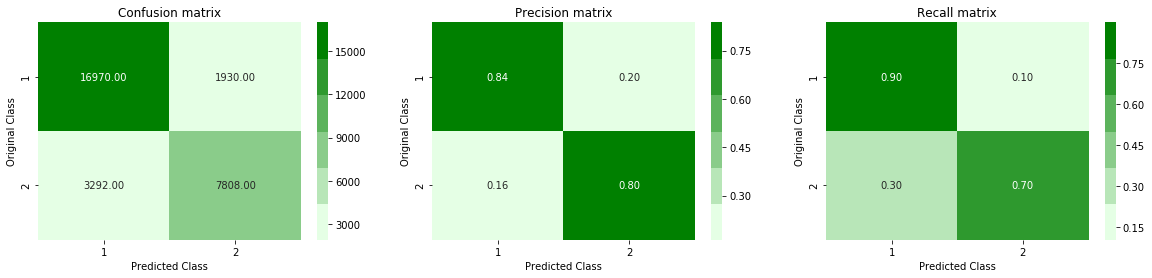

In [151]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

* Gradient boosting in incredibly effective in practice. Perhaps the most popular implementation, XGBoost employs a number of tricks that make it faster and more accurate than traditional gradient boosting. 

* XGBoost stands for Extreme Gradient Boosting. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost is a software library that we can download and install on our machine then access from a variety of interfaces. It is easy to see that the XGBoost objective is a function of functions. 

* We've selected a set of hyperparameters selected without any changes any modifing it. 
* XGBoost implements parallel processing and is blazingly faster as compared to gradient boosting.

* Basic hyperparameters:

**eta**
* which has deafult a value 0.3
* Makes the model more robust by shrinking the weights on each step
                        
**max_depth**
* The maximum depth of a tree, same as GBM
* Should be tuned using CV.
                     
**eval_metric**
* The metric to be used for validation data.
* The default values are rmse for regression and error for classification.
* We used: logloss – negative log-likelihood

# Performing Modeling on the complete dataset with TF-IDF Features

In [152]:
df_basic_feature = pd.read_csv("train_data_fe_ext_without_preprocessing.csv",encoding='latin-1') #Loading Basic Features

print("Total Columns : ",df_basic_feature.columns)
print("Number of columns : ",len(df_basic_feature.columns))

df_basic_feature.head(2)

Total Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')
Number of columns :  17


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [153]:
df_advance_features = pd.read_csv("nlp_features_train_data.csv",encoding='latin-1') #Loading Advance Features

print("Total Columns : ",df_advance_features.columns)
print("\nNumber of columns : ",len(df_advance_features.columns))

df_advance_features.head(2)

Total Columns :  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  21


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [154]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_features = df_advance_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
df_basic_advance_features  = df_basic_feature.merge(df_advance_features, on='id',how='left')

In [155]:
nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)]
print(nan_rows)

            id                         question1  \
105780  105780    How can I develop android app?   
201841  201841  How can I create an Android app?   
363362  363362                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  ...  \
105780          2          2     30      0           6           1  ...   
201841          1          2     32      0           7           1  ...   
363362          1          1      0    123           1          21  ...   

        ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
105780      0.0           0.0            0.0           0.0       0.0   
201841      0.0           0.0            0.0 

In [156]:
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question1'].notnull()]
df_basic_advance_features = df_basic_advance_features[df_basic_advance_features['question2'].notnull()]

nan_rows = df_basic_advance_features[df_basic_advance_features.isnull().any(1)] #Removinf the null values
print(nan_rows)

Empty DataFrame
Columns: [id, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio]
Index: []

[0 rows x 30 columns]


In [158]:
print("Total Columns : ",df_basic_advance_features.columns)
print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head(2)

Total Columns :  Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  30


,id,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [159]:
target = df_basic_advance_features['is_duplicate'] #Making labelled data

In [160]:
df_basic_advance_features.drop(['id','is_duplicate'], axis=1, inplace=True)

print("Total columns : ",df_basic_advance_features.columns)
print("\nNumber of columns : ",len(df_basic_advance_features.columns))

df_basic_advance_features.head(2)

Total columns :  Index(['question1', 'question2', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Number of columns :  28


,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


Performing TF-IDF Tokenization on columns - 'question1' and 'question2'

In [161]:
#Instanciate Tfidf Vectorizer for question 1
tfidfVectorizer_question1 = TfidfVectorizer()
question1_dtm = tfidfVectorizer_question1.fit_transform(df_basic_advance_features['question1'].values.astype('U'))

print("Found {0} features from question1 column".format(len(tfidfVectorizer_question1.get_feature_names())))

Found 68810 features from question1 column


In [162]:
#Instanciate Tfidf Vectorizer for question 1
tfidfVectorizer_question2 = TfidfVectorizer()
question2_dtm = tfidfVectorizer_question2.fit_transform(df_basic_advance_features['question2'].values.astype('U'))

print("Found {0} features from question2 column".format(len(tfidfVectorizer_question2.get_feature_names())))

Found 63536 features from question2 column


In [163]:
from scipy.sparse import hstack
question1_question2 = hstack((question1_dtm,question2_dtm)) #Combining all the features in question1 and question2

In [164]:
df_basic_advance_features.drop(['question1','question2'], axis=1, inplace=True) #Dropping unnecessary question1 and question2 columns

#Combining all basic, advance and tfidf features
df_basic_advance_tfidf_features = hstack((df_basic_advance_features, question1_question2),format="csr",dtype='float64')
df_basic_advance_tfidf_features.shape

(404287, 132372)

Re - Split the data to re train the model

In [165]:
x_train,x_test, y_train, y_test = train_test_split(df_basic_advance_tfidf_features, target, stratify=target, test_size=0.3)

print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (283000, 132372)
Number of data points in test data : (121287, 132372)


Applying ML Models

* Random Model

Log loss on Test Data using Random Model 0.7396358114887448


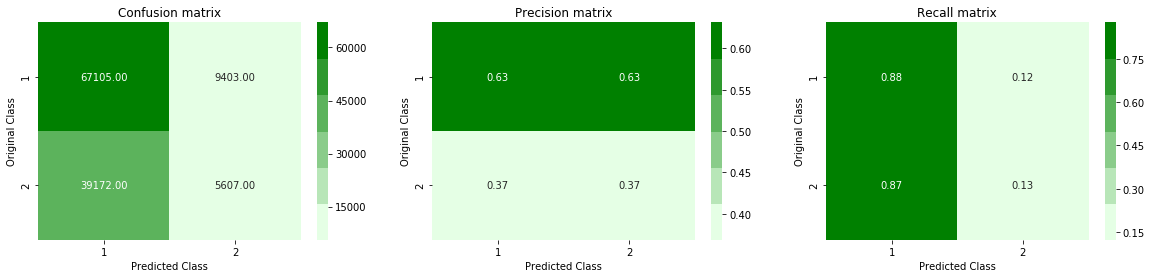

In [166]:
predicted_y = np.zeros((len(y_test),2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.45370231885161566
For values of alpha =  0.0001 The log loss is: 0.45585686627079736
For values of alpha =  0.001 The log loss is: 0.4598860299631028
For values of alpha =  0.01 The log loss is: 0.4489604312169882
For values of alpha =  0.1 The log loss is: 0.4620913971114052
For values of alpha =  1 The log loss is: 0.4923809091598523
For values of alpha =  10 The log loss is: 0.5422858468204217


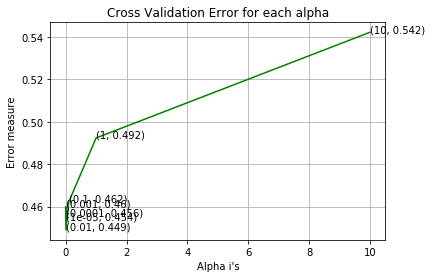

For values of best alpha =  0.01 The train log loss is: 0.44963011410261294
For values of best alpha =  0.01 The test log loss is: 0.4489604312169882
Total number of data points : 121287


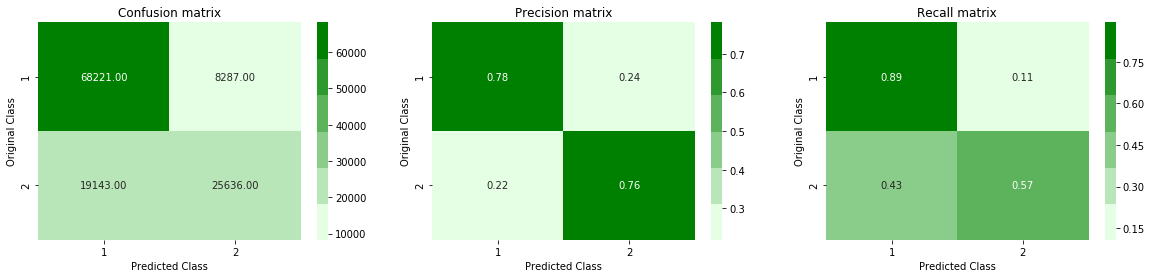

In [167]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=1)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost Model

In [168]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

print("Feature Shape: ",data.shape)
print("Target Shape: ",len(y_true))

feature_train, feature_test, target_train, target_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

Feature Shape:  (100000, 794)
Target Shape:  100000


In [169]:
print("Distribution of output variable in train data")
train_distr = Counter(target_train)
train_len = len(target_train)
print("Class 0: ",int(train_distr[0])/train_len)
print("Class 1: ", int(train_distr[1])/train_len)
print()
print("Distribution of output variable in train data")
test_distr = Counter(target_test)
test_len = len(target_test)
print("Class 0: ",int(test_distr[1])/test_len)
print("Class 1: ",int(test_distr[1])/test_len)

Distribution of output variable in train data
Class 0:  0.6299857142857143
Class 1:  0.37001428571428574

Distribution of output variable in train data
Class 0:  0.37
Class 1:  0.37


In [170]:
n_estimators = [100, 300, 500, 700, 900, 1100, 1300, 1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
colsample_bytree = [0.1, 0.3, 0.5, 0.7 , 0.9, 1]
subsample = [0.1,0.3,0.5,0.7,0.9,1]

def hyperparameter_tunning(X,Y):
    param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample)
    
    model = XGBClassifier(nthread=-1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold) #Using Kfold cross validation
    random_result = random_search.fit(X,Y)
    
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    print()
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return random_result

In [90]:
# start = dt.datetime.now()
# random_result = hyperparameter_tunning(feature_train,target_train)#Tuning hyperparameter values to get the optimal value as entered below
# print("\nTimeTaken: ",dt.datetime.now() - start)

In [171]:
xGBClassifier = XGBClassifier(max_depth=3, 
                              learning_rate=0.1, 
                              n_estimators=1100,
                              subsample=0.3,
                              colsample_bytree= 0.7, 
                              nthread=-1)
xGBClassifier                 #Hyperparameters ran separetely

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1100, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.3, verbosity=1)

In [172]:
start = dt.datetime.now()
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 3
params['colsample_bytree'] = 0.7
params['n_estimators'] = 1100
params['subsample'] = 0.3
params['learning_rate'] = 0.1
params['nthread'] = -1
params['silent'] = 1

d_train = xgb.DMatrix(feature_train, label=target_train)
d_test = xgb.DMatrix(feature_test, label=target_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= False,early_stopping_rounds=20)

xgdmat = xgb.DMatrix(feature_train,target_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(target_test, predict_y, labels=clf.classes_, eps=1e-15))
print("\nTime Taken: ",dt.datetime.now() - start)

The test log loss is: 0.34477146110345813

Time Taken:  0:01:20.729526


Total number of data points : 30000


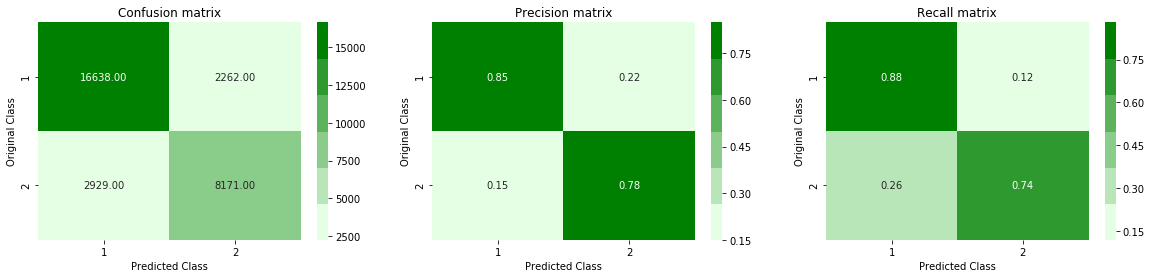

In [173]:
predicted_y =np.array(predict_y > 0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(target_test, predicted_y)

* If we see closely the outpur from the models i.e. the final model with using two different tokeniezer tfidf and weightedw2v with and without hyperparameter tuning gives us pretyy close results.
* Only LR model with hyperparameter tuning gave us an improved result which can tranfer to high dimension data we will use SGD or LR.
* Also, with TFIDF we've got more dimensions which proves out the previous point.
* So the model is generalizing well but I believe it would perform better if we have more columns in our source data as to more features to choose from.
* In a nutshell to run have this model on the go I'd like to run this model on more NLP like features and with more dimensions then we'd end up having a model that'd generalize even better and have a industry standard model.

Comparison with our random model with our final model:

When we create any random model which is like a dumb model i.e. with no parameter tunings, we select predicted_y as np.zeros. The reason behind doing this is to make sure our model gets the best enviornment to run with the given data and perform accordingly. Also, if we'd take a notice we'd see that we're getting a really high logloss value. 

If we compare that with our standard model we'd see couple of changes:

* There's significant changes in the logloss values between the benchmark and the standard models. Even with high parameters tunings. That is different story with two algorithms that I've used.

* First we applied Logistic Regression on less than 100K dataset with hyperparameter tuning, which producs the log loss of 0.52, which is significantly lower than Random Model (0.89) then we applied XGBoost Model on less than 100k dataset with no hyperparameter tuning, which produces the log loss of 0.35, which is significantly low. That says to us is that on low dimesion datawe will use hyperparameter tuned 'XGBoost' model as for high dimension data we will use SGD or LR using hyperparameters tuning.

# Conclusion

In [22]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "Model Comparision"
ptable.field_names = ['Model Name', 'Tokenizer','Hyperparameter Tunning', 'Test Log Loss']
ptable.add_row(["Random","TFIDF Weighted W2V","NA","0.89"])
ptable.add_row(["Logistic Regression","TFIDF Weighted W2V","Done","0.52"])
ptable.add_row(["XGBoost","TFIDF Weighted W2V","NA","0.35"])
ptable.add_row(["XGBoost","TFIDF Weighted W2V","Done","0.34"])
ptable.add_row(["\n","\n","\n","\n"])
ptable.add_row(["Random","TFIDF","NA","0.74"])
ptable.add_row(["Logistic Regression","TFIDF","Done","0.45"])
print(ptable)

+---------------------+--------------------+------------------------+---------------+
|      Model Name     |     Tokenizer      | Hyperparameter Tunning | Test Log Loss |
+---------------------+--------------------+------------------------+---------------+
|        Random       | TFIDF Weighted W2V |           NA           |      0.89     |
| Logistic Regression | TFIDF Weighted W2V |          Done          |      0.52     |
|       XGBoost       | TFIDF Weighted W2V |           NA           |      0.35     |
|       XGBoost       | TFIDF Weighted W2V |          Done          |      0.34     |
|                     |                    |                        |               |
|                     |                    |                        |               |
|        Random       |       TFIDF        |           NA           |      0.74     |
| Logistic Regression |       TFIDF        |          Done          |      0.45     |
+---------------------+--------------------+----------

*Challenges faced:* 

The entire process to this project is to understanding when and how to use NLP related algorithms, fuzzwords and use them to apply on the dataset and make our features ready. This is the most crucial and most difficult part of this project. To getting it to work while keeping the important feature intact, removing stopwords, finding the root words and getting them to apply to our ML algorithms.

One more area where I got stuck multiple time is to how to visualise them in a general form. 

*Other Alternatives:*

However, that being said if given time I'd like to perform this entire project on the basis of Deep learning, as we know most of these NLP technologies are powered by Deep Learning . If we get larger amounts of training data,faster machines and multicore CPU/GPUs. With this our algorithms can be developed with advanced capabilities and improved performance.

I'd like to use other Word@vec models such as Skip-Gram and Continuous Bag of Words, apart from this I think we can also be greatly benefit by doing this project Long short-term memory(LSTM) networks. A great source and starting point would be this article: http://xiaojizhang.com/files/quora-question-pairs.pdf

In this we've tried lowercasing the data, used stemming, stopword removal and also used porterstemmer. 

Apart from this we can also implement 'Lemmatization' which is very similar to stemming, where the goal is to remove inflections and map a word to its root form. The only difference is that lemmatization tries to do it a proper way i.e. it doesn’t chop words off, it actually transforms words to the actual root. Example the word “excellent” may map to “very good”. 

Apart from this we can also do 'Normalization'. It's the process of transforming a text into a standard form. For example, the word “gooood” and “gud” can be transformed to “good”. Another example is mapping of near identical words such as “stopwords”, “stop-words” and “stop words” will just go to “stopwords”.

As far other ML technique goes a linear SVM would be another good model to select to do check the performance of the algorithm.

Step By Step Process of Model Implementation

**Tokenizer: TFIDF Weighted W2V**

* First we have applied simple Random Model which is a dumb model in sense, which gives the log loss of 0.89 which means, other models has to produce less than 0.89.
* After that we have applied Logistic Regression on less than 100K dataset with hyperparameter tuning, which producs the log loss of 0.52, which is significantly lower than Random Model.
* We then applied XGBoost Model on less than 100k dataset with no hyperparameter tuning, which produces the log loss of 0.35, which is significantly low.
* Lastly, we applied XGBoost Model on same 100k dataset with hyperparameter tuning, which produces the log loss of 0.34, which is slightly lower than XGBoost Model with no hyperparameter tuning. We know that on high dimension dataset 'XGBoost' does not perform well, but it did farely well in the above dataset because of low dimension of 794. Whereas 'Logistic Regression' and performs moderately on low dimension data.

To check on this we performed the same task on around 400k dataset, and we should get better results as compared to above models.

**Tokenizer: TFIDF**

* First we have applied simple Random Model which is a dumb model in sense, which gives the log loss of 0.74 which means, other models has to produce less than 0.74.
* After that we have applied Logistic Regression on 400K dataset with hyperparameter tuning, which producs the log loss of 0.45, which is significantly lower than Random Model. Also, lower than previous LR model.

Therefore we can say that on low dimesion data,we will use hyperparameter tuned 'XGBoost' model and for high dimension data we will use SGD or LR using hyperparameters tuning.

In [18]:
# !set PATH=/Library/TeX/texbin:$PATH

'C:\\Users\\sys26\\Desktop\\todayscaptone'

In [21]:
import sys
if r"\your\path\to\xelatex" not in sys.path:
    print('adding path') # I just add this to know if the path was present or not.
    sys.path.append(r"\your\path\to\xelatex")

adding path
